### 1️⃣ Importaciones y configuración

In [ ]:
import sys
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("__file__"), "..", ".."))
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

TRAIN_CSV = os.path.join(OUTPUT_DIR, "train_processed.csv")
VAL_CSV   = os.path.join(OUTPUT_DIR, "val_processed.csv")
TEST_CSV  = os.path.join(OUTPUT_DIR, "test_processed.csv")

sys.path.insert(0, BASE_DIR)

from src.part_2.main import run_training
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.neural_network import MLPRegressor
import pandas as pd
from sklearn.linear_model import LinearRegression


### 2️⃣ Funciones de evaluación de métricas

In [ ]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    return {
        "MSE": float(mse),
        "MAE": float(mae),
        "MAPE": float(mape_val)
    }


### 3️⃣ Funciones de entrenamiento de los modelos BP-F y MLR-F

In [32]:
def train_bp_f(X_train, y_train, X_test, activation="identity"):
    """
    BP-F model using scikit-learn's MLPRegressor
    """
    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation=activation,
        solver="adam",
        max_iter=500,
        tol=1e-4,
        random_state=42
    )
    mlp.fit(X_train, y_train)
    preds = mlp.predict(X_test)
    return preds, mlp

def train_mlr_f(X_train, y_train, X_test):
    """
    MLR-F model using scikit-learn's LinearRegression
    """
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    return preds, lr


### 4️⃣ Cargar datos usando las variables del notebook


In [ ]:
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)

# Drop PID and separate features and target
X_train = df_train.drop(columns=["SalePrice", "PID"])
y_train = df_train["SalePrice"]

X_test  = df_test.drop(columns=["SalePrice", "PID"])
y_test  = df_test["SalePrice"]



### 5️⃣ Feature Scaling


In [ ]:
activation_function = "linear"  # Example activation function ["linear", "sigmoid", "tanh", "relu"]

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

if activation_function == "tanh" or activation_function == "sigmoid":
    y_train_transformed = np.log1p(y_train)
else:
    y_train_transformed = y_train


### 5️⃣ Entrenamiento y predicción de los modelos

In [ ]:
# BP Custom Neural Network

nn, pid_test, y_test_values, preds_bp, trainer = run_training(activation_function, verbose=True, CSV_TRAIN=TRAIN_CSV, CSV_VAL=VAL_CSV, CSV_TEST=TEST_CSV)

print("BP Custom:")
bp_custom_evaluation = evaluate_model(y_test_values, preds_bp)


In [33]:
# BP-F Model
activation_map_bp_f = {
    "linear": "identity",
    "sigmoid": "logistic",
    "tanh": "tanh",
    "relu": "relu"
}

activation_bp_f = activation_map_bp_f[activation_function]

preds_bp_f, bp_f_model = train_bp_f(X_train_scaled, y_train_transformed, X_test_scaled, activation_bp_f)

print("BP-F:")
bpf_evaluation = evaluate_model(y_test, preds_bp_f)


/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


BP-F:


/opt/homebrew/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# MLR-F Model
preds_mlr_f, mlr_model = train_mlr_f(X_train, y_train, X_test)

print("MLR-F:")
mlfr_evaluation = evaluate_model(y_test, preds_mlr_f)

In [34]:
# Comparative Metrics
metrics = pd.DataFrame({
    "BP Custom": bp_custom_evaluation,
    "BP-F": bpf_evaluation,
    "MLR-F": mlfr_evaluation
}).T

display(metrics)


,MSE,MAE,MAPE
BP Custom,5.206197e+08,16585.978515,9.674769
BP-F,3.758262e+08,13530.236895,8.123118
MLR-F,4.418003e+08,13784.441236,8.424560


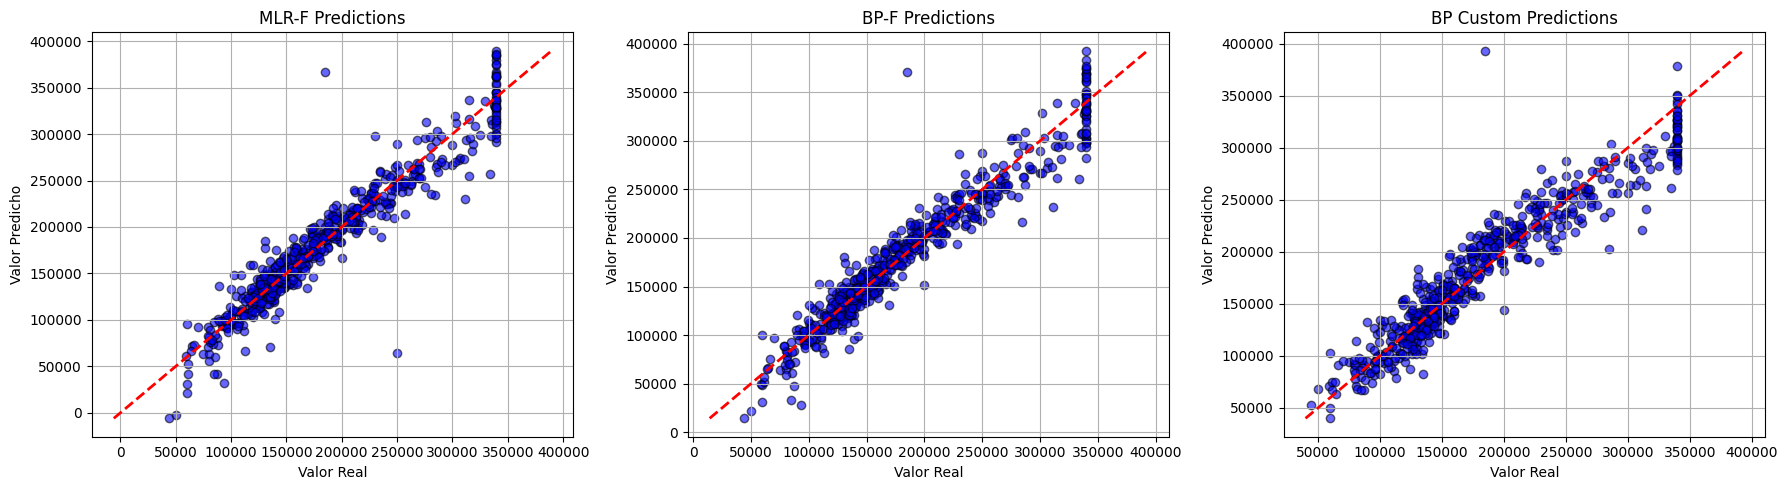

In [35]:
model_results = {
    "MLR-F": (y_test, preds_mlr_f),
    "BP-F": (y_test, preds_bp_f),
    "BP Custom": (y_test_values, preds_bp)
}

plt.figure(figsize=(18, 5))

for i, (model_name, (y_true, y_pred)) in enumerate(model_results.items(), start=1):
    plt.subplot(1, 3, i)
    plt.scatter(y_true, y_pred, alpha=0.6, color='b', edgecolor='k')
    
    # Línea diagonal y=x para referencia
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    plt.title(f"{model_name} Predictions")
    plt.xlabel("Valor Real")
    plt.ylabel("Valor Predicho")
    plt.grid(True)

plt.tight_layout()
plt.show()
